In [40]:
#Libraries

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

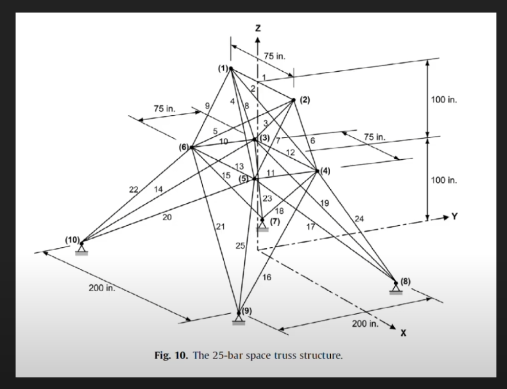

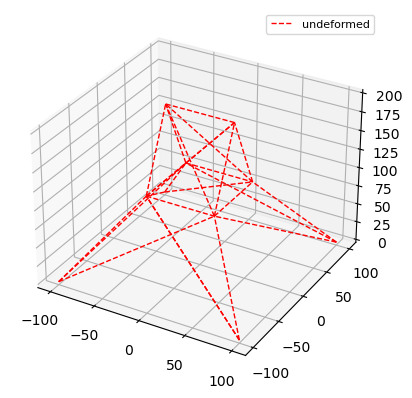

In [41]:
#Input

E = 1e4 #modulo de elasticidade
A = 0.111 #area da seçao

#coordenadas x, y ,z
nodes = np.array([[-37.5,0,200],
                 [37.5,0,200],
                 [-37.5,37.5,100],
                 [37.5,37.5,100],
                 [37.5,-37.5,100],
                 [-37.5,-37.5,100],
                 [-100,100,0],
                 [100,100,0],
                 [100,-100,0],
                 [-100,-100,0]]).astype(float)




bars = np.array([[0,1],
                    [3,0],
                    [2,1],
                    [4,0],
                    [5,1],
                    [3,1],
                    [4,1],
                    [2,0],
                    [5,0],
                    [5,2],
                    [4,3],
                    [2,3],
                    [5,4],
                    [9,2],
                    [6,5],
                    [8,5],
                    [7,4],
                    [6,3],
                    [7,2],
                    [9,4],
                    [8,5],
                    [9,5],
                    [6,2],
                    [7,3],
                    [8,4]])

                    
#Aply forces
P = np.zeros_like(nodes)
#Aply forces 
#P[node_number, direction(x=0, y=1, z= 2)]
P[0,0] = 1
P[0,1] = -10
P[0,2] = -10
P[1,1] = -10
P[1,2] = -10
P[2,0] = 0.5
P[5,0] = 0.5

#Suport displacement
Ur = [0,0,0,0,0,0,0,0,0,0,0,0]

#Condicon of DoF (free = 1; fixed = 0)
DOFCON = np.ones_like(nodes).astype(int)

DOFCON[6,:] = 0 #nó 7 engastado
DOFCON[7,:] = 0 #nó 8 engastado
DOFCON[8,:] = 0
DOFCON[9,:] = 0

def plot_undeformed(nodes, c,lt,lw,lg,scale=1):
    for i in range(len(bars)):
        xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
        yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
        zi, zf = nodes[bars[i,0],2], nodes[bars[i,1],2]
        line, = ax.plot([xi,xf],[yi, yf],[zi, zf], color=c, linestyle=lt, linewidth=lw)
    line.set_label(lg)
    if scale != 1:
        line.set_label(lg+", scale: "+str(scale)+"x")
    ax.legend(prop={'size': 8})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_undeformed(nodes,'r','--',1,"undeformed",1)
plt.show()

Axial forces (+ = tension; - = compression)
[[  1.83768936]
 [  3.23757511]
 [  4.53562223]
 [ -8.17529956]
 [ -7.7332956 ]
 [  5.18819972]
 [-13.25133361]
 [  6.25047883]
 [-12.88961209]
 [  0.44361218]
 [  1.8346726 ]
 [ -1.49727338]
 [  3.00264851]
 [  1.71032834]
 [ -4.47627117]
 [ -4.66667982]
 [ -5.88954779]
 [  3.8251204 ]
 [  3.82269442]
 [ -9.03388194]
 [ -4.66667982]
 [-13.84150057]
 [  8.37277458]
 [  6.97616715]
 [-13.92492246]]
Reaction forces (+ = tension; - = compression)
[[ -5.27999289   1.84289024  -5.91398813]
 [  4.13650328   0.11525297  -4.08601187]
 [-13.60563544   9.74125742  15.58601187]
 [ 12.74912505   8.30059937  14.41398813]]
Deformation at nodes
[[ 3.06088179e-01 -6.64645355e+00 -6.78020357e-01]
 [ 4.30256379e-01 -7.06163269e+00 -1.02268185e+00]
 [ 1.06792282e-01 -4.19008553e-01  1.01497851e+00]
 [ 5.62516184e-03 -1.22823448e-01  1.04623735e+00]
 [-2.17957521e-01 -2.46787813e-01 -2.21655477e+00]
 [-4.20839177e-01 -4.48982348e-01 -1.67754829e+00]
 [ 0.0000000

<Figure size 640x480 with 0 Axes>

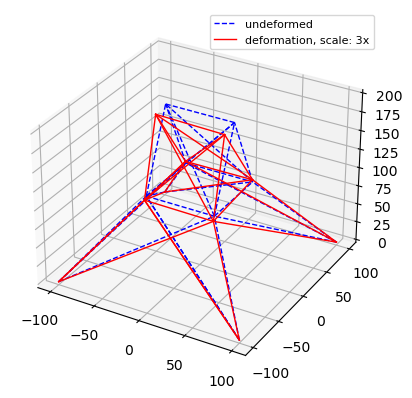

In [42]:
def TrussAnalisys():
    NN = len(nodes)
    NE = len(bars)
    DOF = 3
    NDOF = DOF*NN

    d = nodes[bars[:,1],:] - nodes[bars[:,0],:]
    L = np.sqrt((d**2).sum(axis=1))
    angle = d.T/L
    a = np.concatenate((-angle.T,angle.T),axis=1)
    K = np.zeros([NDOF,NDOF])
    
    for k in range(NE):
        aux = DOF*bars[k,:]
        index = np.r_[aux[0]:aux[0]+DOF,aux[1]:aux[1]+DOF]

        ES = np.dot(a[k][np.newaxis].T*E*A,a[k][np.newaxis])/L[k]
        K[np.ix_(index,index)] = K[np.ix_(index,index)]+ES

    freeDOF = DOFCON.flatten().nonzero()[0]
    supportDOF = (DOFCON.flatten() == 0).nonzero()[0]
    Kff = K[np.ix_(freeDOF,freeDOF)]
    Kfr = K[np.ix_(freeDOF,supportDOF)]
    Krf = Kfr.T
    Krr = K[np.ix_(supportDOF,supportDOF)]
    Pf = P.flatten()[freeDOF]
    Uf = np.linalg.solve(Kff,Pf)
    U = DOFCON.astype(float).flatten()
    U[freeDOF] = Uf
    U[supportDOF] = Ur
    U = U.reshape(NN,DOF)
    u = np.concatenate((U[bars[:,0]],U[bars[:,1]]),axis=1)
    N = E*A/L[:]*(a[:]*u[:]).sum(axis=1)
    R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1)
    R = R.reshape(4,DOF)
    return np.array(N), np.array(R), U
   

def plot_deformation(nodes, c,lt,lw,lg,scale=1):
    for i in range(len(bars)):
        xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
        yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
        zi, zf = nodes[bars[i,0],2], nodes[bars[i,1],2]
        line, = ax.plot([xi,xf],[yi, yf],[zi, zf], color=c, linestyle=lt, linewidth=lw)
    line.set_label(lg)
    if scale != 1:
        line.set_label(lg+", scale: "+str(scale)+"x")
    ax.legend(prop={'size': 8})
    


def plt_tension(nodes,lt,lw,lg,scale=1):

    colors = plt.cm.jet(np.linspace(-1, 1, len(bars)+1))
    for i in range(len(bars)):
        val = ((N[i]-np.min(N))/(np.max(N)-np.min(N)))*len(bars)
        xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
        yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
        zi, zf = nodes[bars[i,0],2], nodes[bars[i,1],2]
        #print(str(val)+" "+str(int(val)))
        line, = ax.plot([xi,xf],[yi, yf],[zi, zf], color = colors[int(val)], linestyle=lt, linewidth=lw)
 
    #line.set_label(lg)
    line.set_label(lg+", scale: "+str(scale)+"x")
    ax.legend(prop={'size': 8})

fig = plt.figure()

#executa a análise
N, R, U = TrussAnalisys()
print("Axial forces (+ = tension; - = compression)")
print(N[np.newaxis].T)
print("Reaction forces (+ = tension; - = compression)")
print(R)
print("Deformation at nodes")
print(U)

#configura o plot das imagens
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')


#plota a figura indeformada
#plot_deformation(nodes, 'gray', '--', 1, 'Undeformed')

#plota a figura deformada
scale = 3
Dnodes = U*scale + nodes
#plot_deformation(Dnodes, 'red', '-', 2, 'Deformed',scale)

#Exibe o plot
#plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#plt_tension(Dnodes,'-',2,"tensão",15)
plot_undeformed(nodes,'b','--',1,"undeformed",1)
plot_deformation(Dnodes,'r','-',1,"deformation",scale)
plt.show()


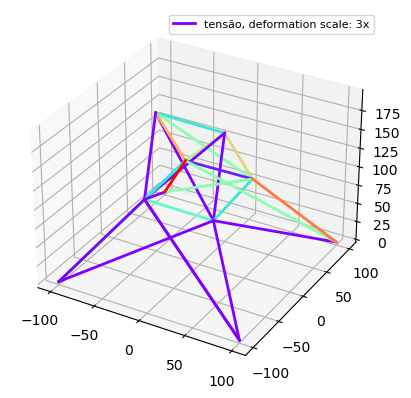

In [43]:
def plt_tension(nodes,lt,lw,lg,scale=1):

    colors = plt.cm.rainbow(np.linspace(-1, 1, len(bars)+1))
    for i in range(len(bars)):
        val = ((N[i]-np.min(N))/(np.max(N)-np.min(N)))*len(bars)
        xi, xf = nodes[bars[i,0],0], nodes[bars[i,1],0]
        yi, yf = nodes[bars[i,0],1], nodes[bars[i,1],1]
        zi, zf = nodes[bars[i,0],2], nodes[bars[i,1],2]
        #print(str(val)+" "+str(int(val)))
        line, = ax.plot([xi,xf],[yi, yf],[zi, zf], color = colors[int(val)], linestyle=lt, linewidth=lw)
 
    #line.set_label(lg)
    line.set_label(lg+", deformation scale: "+str(scale)+"x")
    ax.legend(prop={'size': 8})

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
plt_tension(Dnodes,'-',2,"tensão",scale)
plt.show()
